# Поиск изменений во временном ряде

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

In [2]:
from collections import defaultdict
np.random.seed(seed=111111)
np.set_printoptions(precision=3, suppress=True)

## Пример сигнала

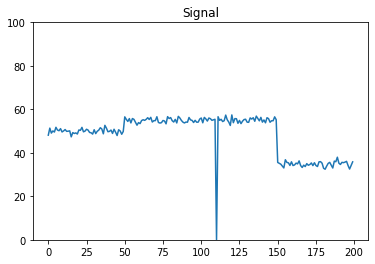

In [3]:
signal = np.random.normal(scale=1, size=200)
signal[:50] += 50; signal[50:] += 55; signal[150:] -= 20
signal[110] = 0

plt.plot(signal)
plt.ylim(0,100)
plt.title("Signal")
plt.show()

## Что такое поиск точек изменения?

В этом сигнале есть несколько точек изменения. Мы хотим иметь возможность обнаруживать эти типы изменений и различать важные изменения и незначительные изменения.

  * Мы можем решить, что незначительные колебания или шум сигнала не важны и должны быть проигнорированы нашим алгоритмом обнаружения изменений.
  * А как насчет незначительных изменений в точке 50? Это важно?

У нас нет информации о будущем поведении сигнала. Поэтому, когда мы сталкиваемся с изменением в точке 50, мы должны решить, важно это или нет БЕЗ ЗНАНИЯ о более крупном изменении в 150, или о резком падении в 110.

  * Резкое падение в точке 110 - это изменение с наибольшей величиной в нашем сигнале. Но почему это так? Что-то важное происходит? или точка отсутствует в выборке и интерпретируется как «0»?

## Является ли точка - точкой изменений зависит от кучи факторов

### Сломанный тренд или сезонность

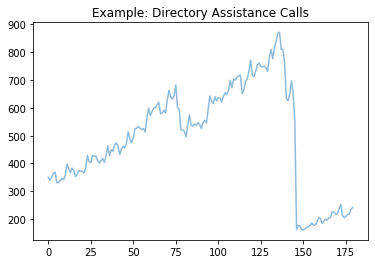

In [4]:
signal = [350,339,351,364,369,331,331,340,346,341,357,398,381,367,383,375,353,361,375,371,373,366,382,429,406,403,429,425,427,409,402,409,419,404,429,463,428,449,444,467,474,463,432,453,462,456,474,514,489,475,492,525,527,533,527,522,526,513,564,599,572,587,599,601,611,620,579,582,592,581,630,663,638,631,645,682,601,595,521,521,516,496,538,575,537,534,542,538,547,540,526,548,555,545,594,643,625,616,640,625,637,634,621,641,654,649,662,699,672,704,700,711,715,718,652,664,695,704,733,772,716,712,732,755,761,748,748,750,744,731,782,810,777,816,840,868,872,811,810,762,634,626,649,697,657,549,162,177,175,162,161,165,170,172,178,186,178,178,189,205,202,185,193,200,196,204,206,227,225,217,219,236,253,213,205,210,216,218,235,241]
plt.plot(signal, alpha = 0.5)
plt.title('Example: Directory Assistance Calls')
plt.show()

## Нарушение периодичности

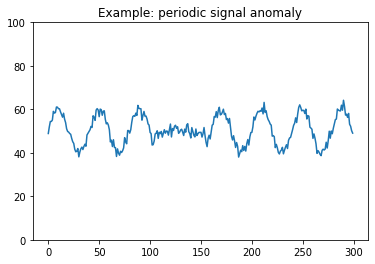

In [5]:
signal = np.sin(np.linspace(0, 15*np.pi, num=300))
signal[105:155] *= 0.1
signal = 10 * signal + 50

noise = np.random.normal(scale = 1.5, size=300)
signal = signal + noise

plt.ylim(0,100)
plt.plot(signal)
plt.title('Example: periodic signal anomaly')
plt.show()

## 1. Простое мат ожидание

Рассмотрим сигнал

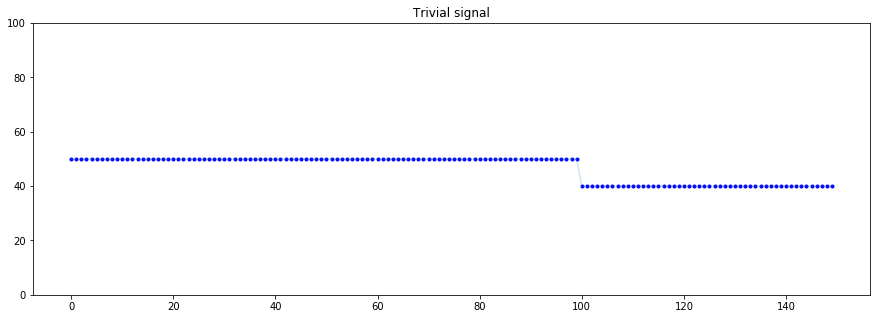

In [6]:
sig1 = np.ones(150)
sig1[:100] *= 50
sig1[100:] *= 40

plt.figure(figsize=(15, 5))
plt.plot(sig1, 'b.')
plt.plot(sig1, '-', alpha=0.2)
plt.ylim(0,100)
plt.title("Trivial signal")
plt.show()

Давайте рассмотрим простой детектор:
* Расчитываем среднее значение в каждой точке
* Сигнализируем об изменении, если значение сигнала превосходит мат ожидание на какой-то порог

In [7]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [8]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

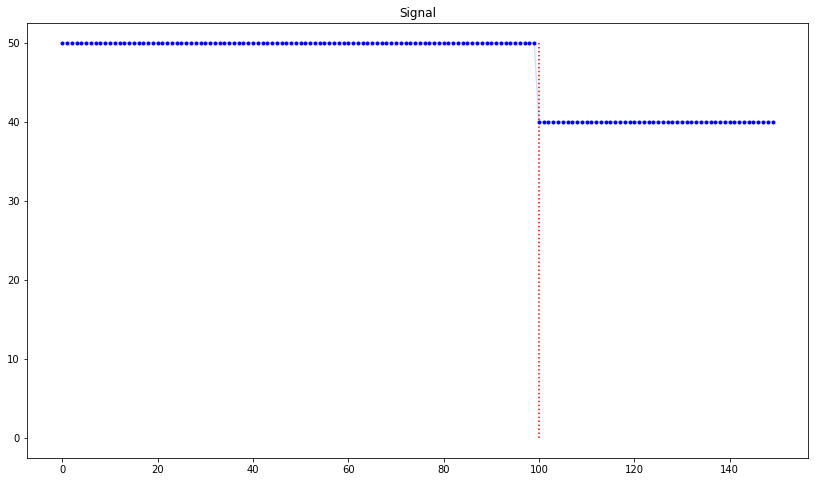

In [9]:
simulate(MeanDetector(), sig1)

### Насколько хорош?

### Масштабирование

## Практика
Примените детектор к отмасштабированному в 1000 раз сигналу

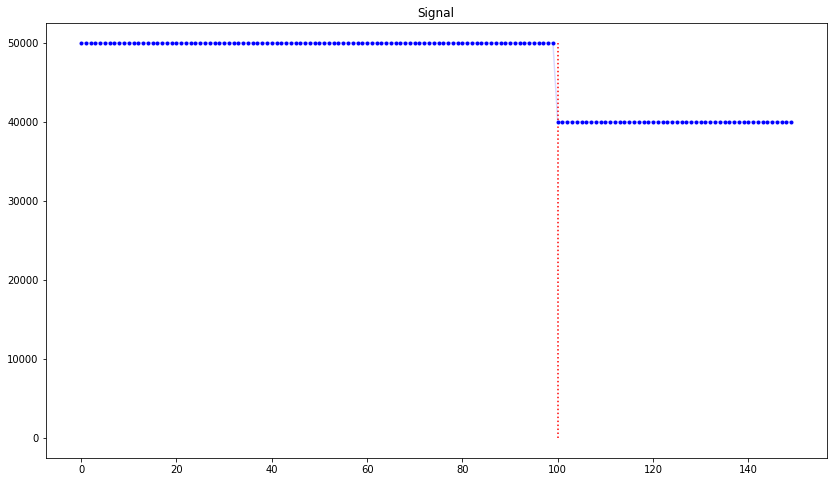

In [10]:
simulate(MeanDetector(), sig1 * 1000)

### Зашумление

## Практика
Примените детектор к сигналу к которому мы прибавили гауссовом шум с размахом 0.02, 0.1, 0.2 от высоты перепада

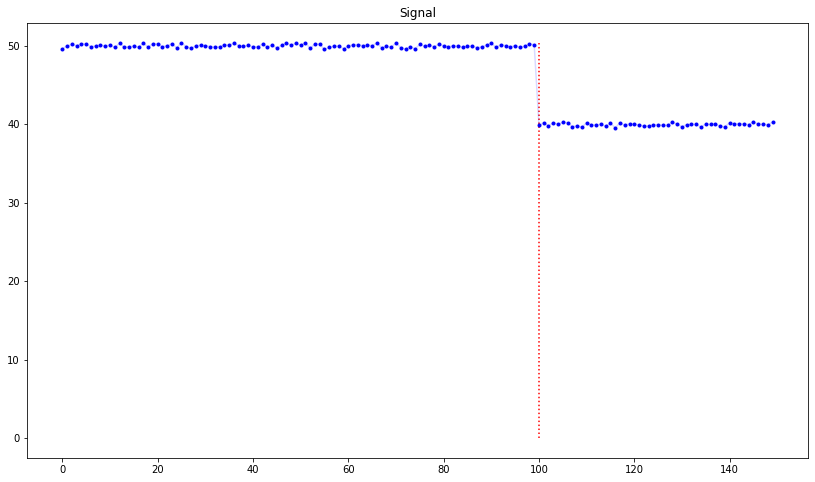

In [11]:
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size = sig1.shape, 
    scale = jump_size * 0.02)

simulate(MeanDetector(), sig1 + noise)

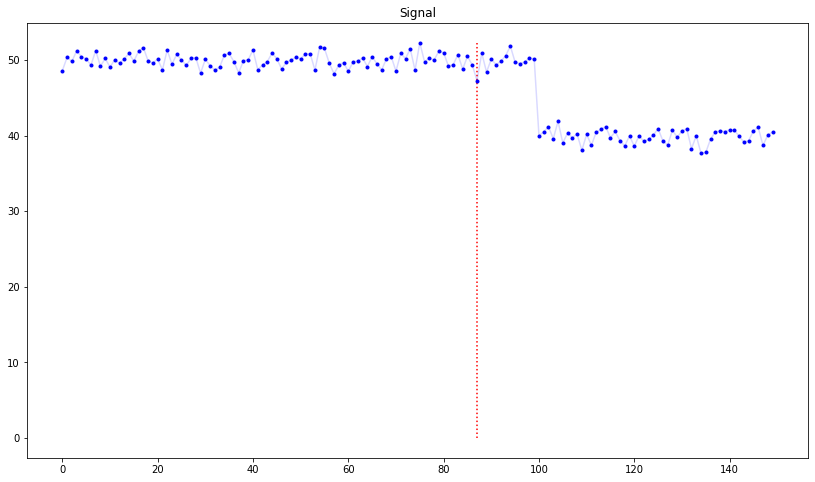

In [12]:
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size = sig1.shape, 
    scale = jump_size * 0.10)

simulate(MeanDetector(), sig1 + noise)

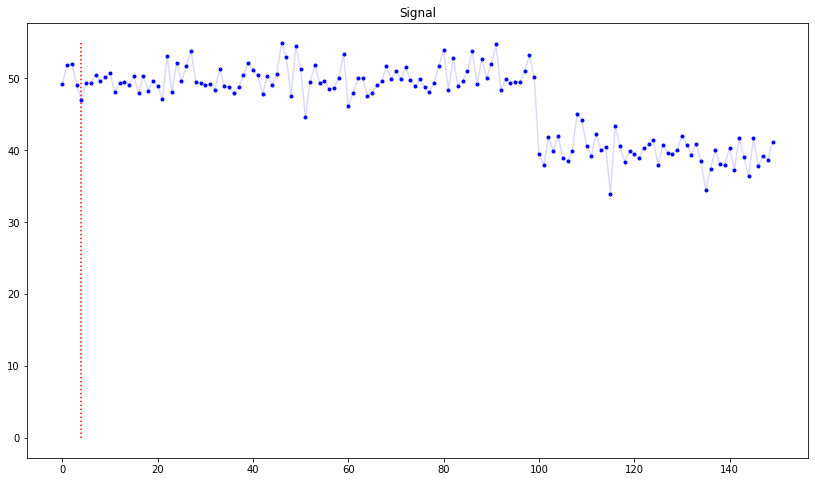

In [13]:
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size = sig1.shape, 
    scale = jump_size * 0.20)

simulate(MeanDetector(), sig1 + noise)

### Еще недостатки

  * Чувствительность к пороговому значению, которое мы определяем вручную.
  * Чувствительность к аномальным значениям и выбросам
  * Сигнал должен быть постоянным. детектор плохо работает с трендом или локальным изменением (сезонность)

Ручная настройка и эвристика могут решить некоторые из этих проблем, но зачастую его конечно не хватает

## Сигнал с сезонностью

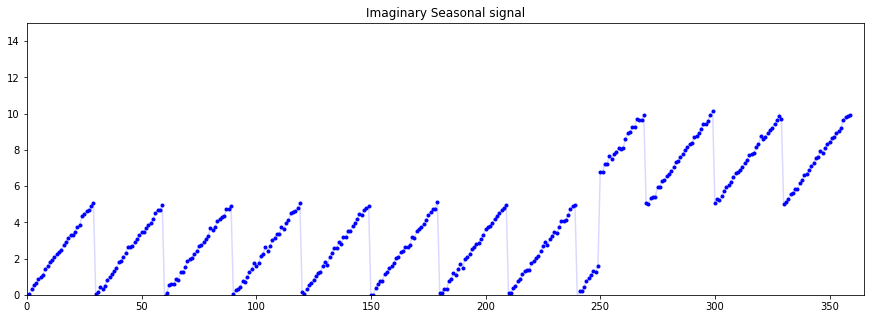

In [14]:
sig2 = np.linspace(0, 5, num=30)
sig2 = np.concatenate([sig2 for x in range(12)])

jump_size = 5
sig2[250:] = sig2[250:] + jump_size

# Noise
noise = np.random.normal(
    size=sig2.shape,
    scale=jump_size * 0.02)

plt.figure(figsize=(15,5))
plt.plot(sig2 + noise, 'b.', linestyle='')
plt.plot(sig2 + noise, 'b-', alpha=0.15)
plt.ylim(0,15)
plt.xlim(0,365)
plt.title("Imaginary Seasonal signal")
plt.show()

## Практика; Примените детектор к сигналу с сезонностью

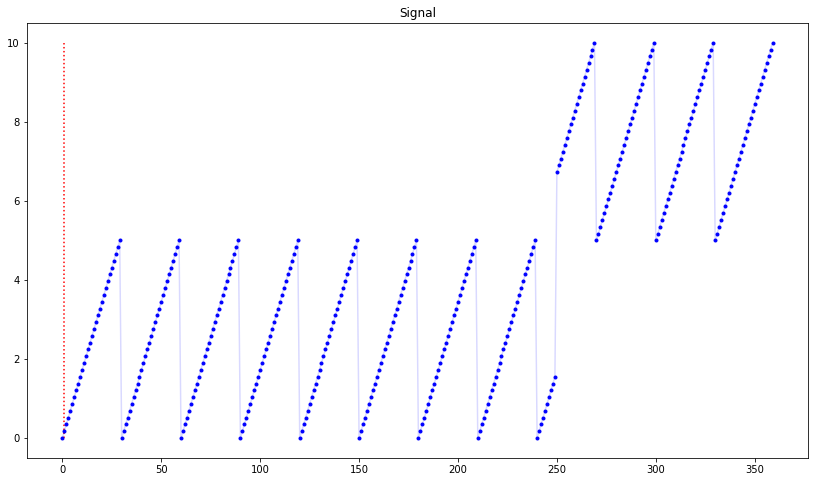

In [15]:
simulate(MeanDetector(threshold=0.05), sig2)

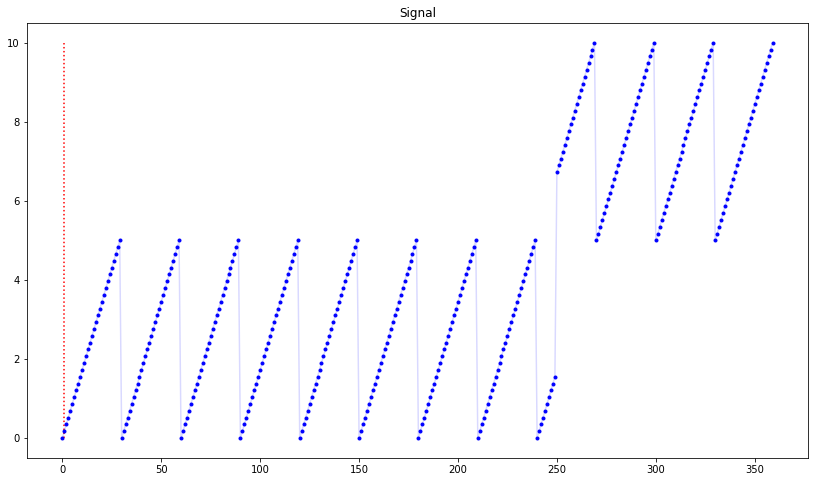

In [16]:
simulate(MeanDetector(threshold=0.5), sig2)

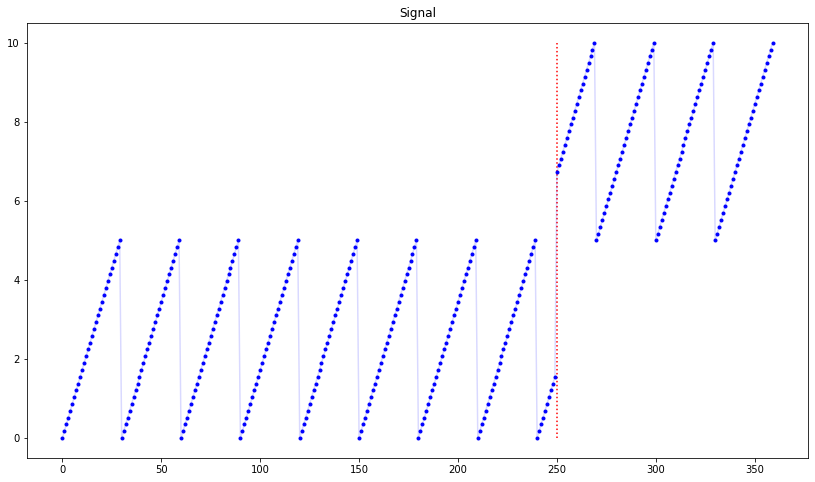

In [17]:
simulate(MeanDetector(threshold=1.7), sig2)

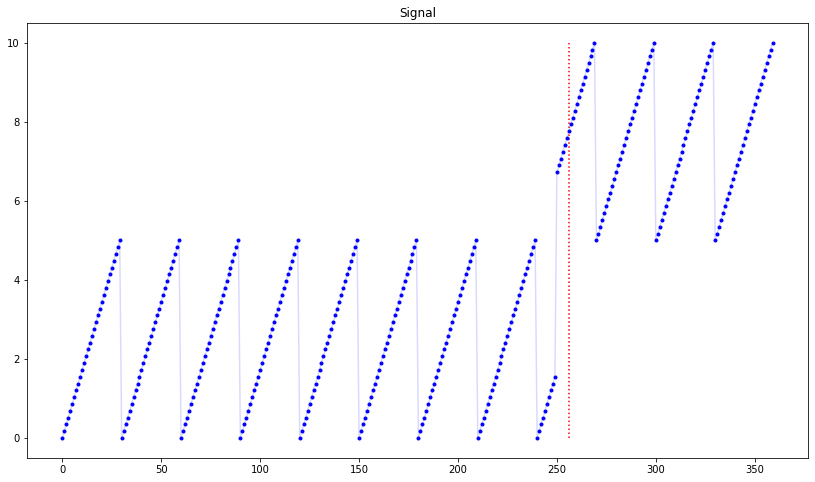

In [18]:
simulate(MeanDetector(threshold=2), sig2)

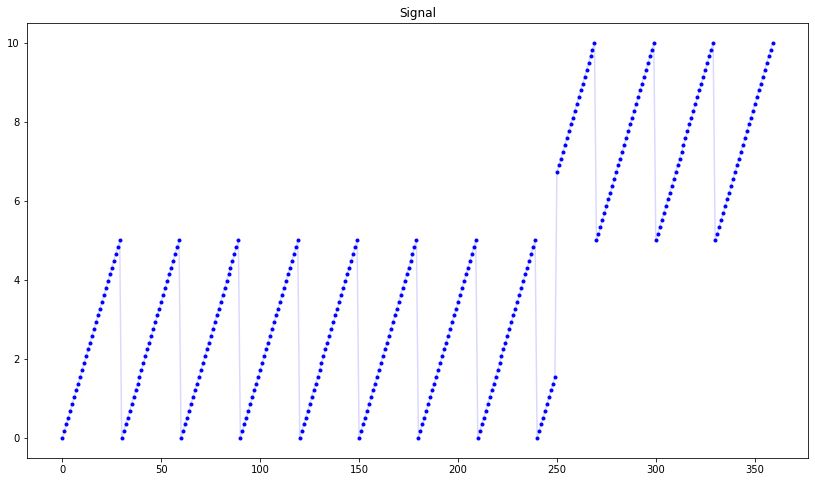

In [19]:
simulate(MeanDetector(threshold=5), sig2)

## 2. Потоковые окна

Потоковые окна - это подход к обнаружению изменений, где мы сохраняем статистику (например, среднее значение) на двух отдельных образцах (или окнах) сигнала.

Обычно для одного из окон мы используем только последние $n$ точки данных. Для другого окна мы можем использовать гораздо большее окно или весь сигнал, который мы видели с момента $t = 0$.

Затем мы можем сравнить то, что происходило «недавно» с тем, как сигнал вел себя раньше.

### Остерегайтесь практических ограничений
Зачастую нельзя хранить все данные - нужны "умные" алгоритмы для хранения статистик по точкам.

#### Метод Велфорда
В этом разделе мы будем использовать метод Welford для вычисления среднего значения и дисперсии. 

## zscore

### Zscore (определение)
При сравнении двух гауссовских моделей z-оценка - это расстояние от среднего значения выборки до среднего значения совокупности в единицах стандартной ошибки. Он часто используется для определения того, отличается ли выборка точек данных от исследуемой совокупности.

$$z_{score} = \frac{(M - \sigma)}{SE}$$

 * Совокупность имеет среднее значение $\mu$ и стандартное отклонение $\sigma$.
 * Выборка имеет среднее значение $M$ и размер $n$.
 * SE - это стандартная ошибка:
$$SE = \frac{\sigma}{\sqrt{n}}$$
    

### Использование Zscore

Для нашего следующего детектора точек изменений мы будем поддерживать два набора статистических данных о нашем сигнале и сравнивать их с помощью z-score. Ссылаясь на приведенные выше формулы, нам нужно вычислить среднее и стандартное отклонение для каждого набора.

Мы будем использовать весь сигнал, который мы видели до сих пор, для вычисления статистик совокупности.
Мы будем использовать движущееся окно из последних $n$ точек для вычисления статистик выборки.

In [20]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

## Проверим на первом ряде

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


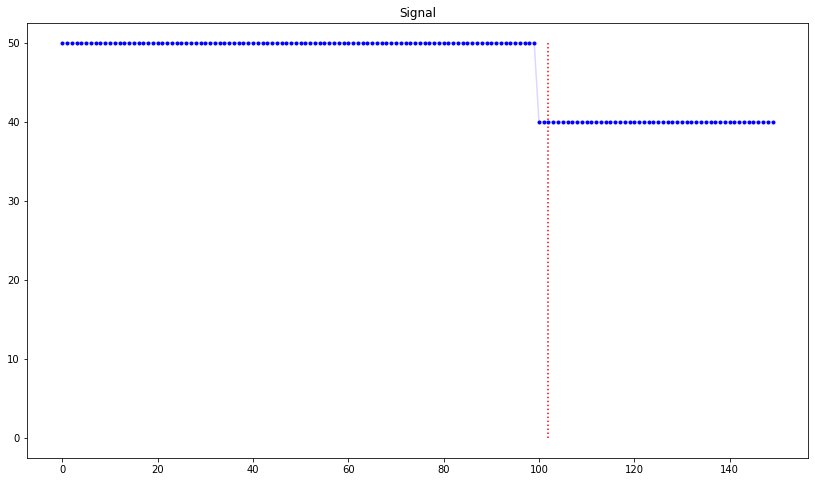

In [21]:
simulate(ZScoreDetector(window_size=10, threshold=5.0), sig1)

### Сработало?

Изменеение было заметно не сразу. «Изменение произошло где-то в нашем локальном окне». Чем больше окно, тем меньше вероятность того, что мы находимся именно там, где произошли изменения.

### Торг в обнаружении изменений
Компромисс между задержкой обнаружения и частотой ложных срабатываний.

### Сезонность

### Практика
Примените детектор к сигналу с сезонностью

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


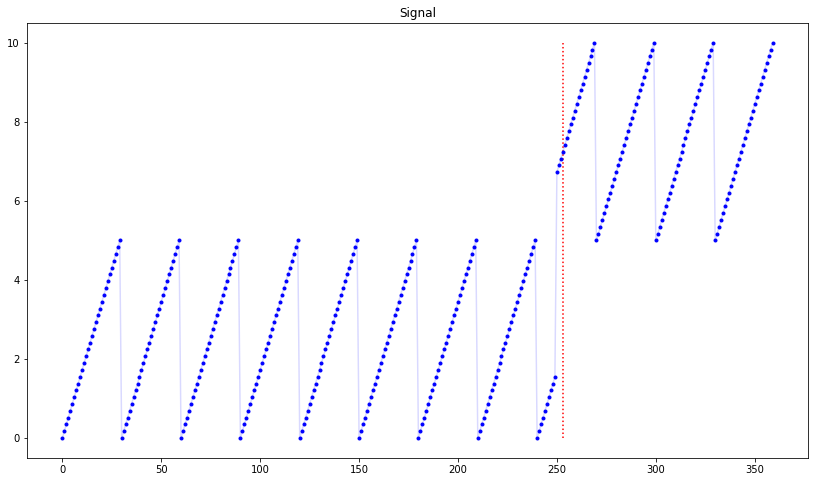

In [22]:
simulate(ZScoreDetector(window_size=30, threshold=2), sig2[:360])

In [23]:
def sig1_with_zeros(num_zeros):
    tmp = sig1.copy()
    tmp[50:50+num_zeros] = 0
    
    simulate(ZScoreDetector(window_size=10, threshold=3.), tmp)

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


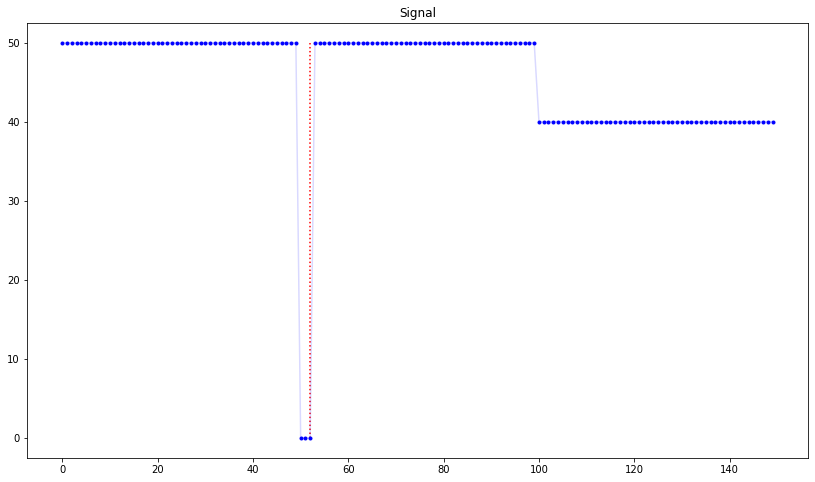

In [24]:
sig1_with_zeros(3)

## Выбросы?

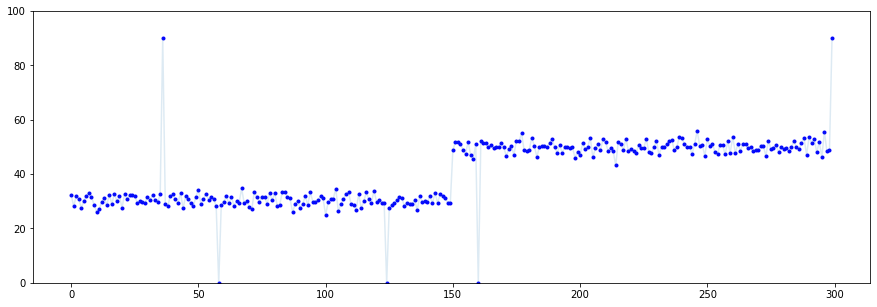

In [25]:
jump_size = 20
signal_size = 300

sig3 = np.ones(signal_size)
sig3[:150] = 30
sig3[150:] = 30 + jump_size

noise = np.random.normal(
    scale = 0.10 * jump_size,
    size=signal_size)

sig3 = sig3 + noise

outlier_idx = np.random.choice(signal_size, size=3)
sig3[outlier_idx] = 0
outlier_idx = np.random.choice(signal_size, size=2)
sig3[outlier_idx] = 90

plt.figure(figsize=(15, 5))
plt.plot(sig3, 'b.')
plt.plot(sig3, '-', alpha=0.15)
plt.ylim(0,100)
plt.show()

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


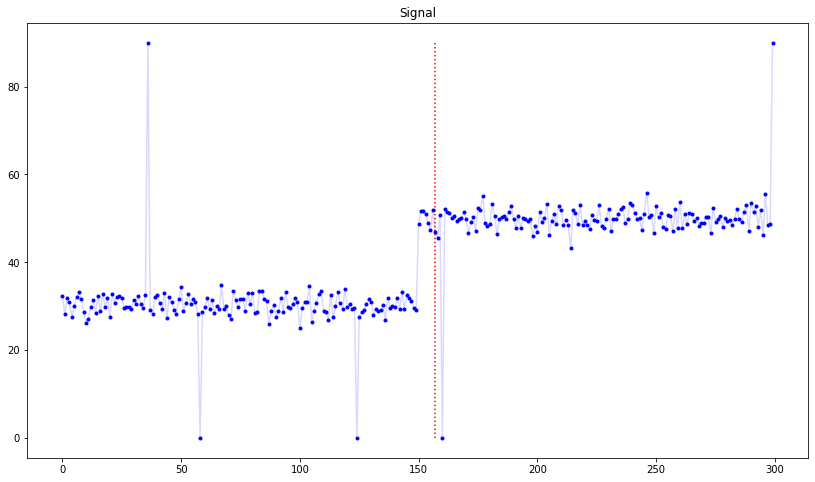

In [26]:
simulate(ZScoreDetector(window_size=30, threshold=3.0), sig3)

### 3. Кумулятивные суммы

Алгоритм [Кумулятивная сумма (CUSUM)](http://en.wikipedia.org/wiki/CUSUM) является классическим методом мониторинга обнаружения изменений. Одной из форм реализации алгоритма CUSUM является вычисление суммарной суммы положительных и отрицательных изменений ($g_t^+$ и $g_t^-$) в данных и сравнение результата с некоторым порогом. Когда этот порог превышен - обнаружено изменение. Чтобы избежать обнаружения изменения (например, при наличии тренда) - в алгоритм добавляют параметр для его учета ($drift$):

$$ \begin{array}{l l} 
\left\{ \begin{array}{l l} 
s[t] = x[t] - x[t-1] \\
g^+[t] = max\left(g^+[t-1] + s[t]-drift,\; 0\right) \\
g^-[t] = max\left(g^-[t-1] - s[t]-drift,\; 0\right)
\end{array} \right. \\
\\
\; if \;\;\; g^+[t] > threshold \;\;\; or \;\;\;  g^-[t] > threshold: \\
\\
\left\{ \begin{array}{l l} 
t_{talarm}=t \\
g^+[t] = 0 \\
g^-[t] = 0 
\end{array} \right.
\end{array} $$

In [27]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

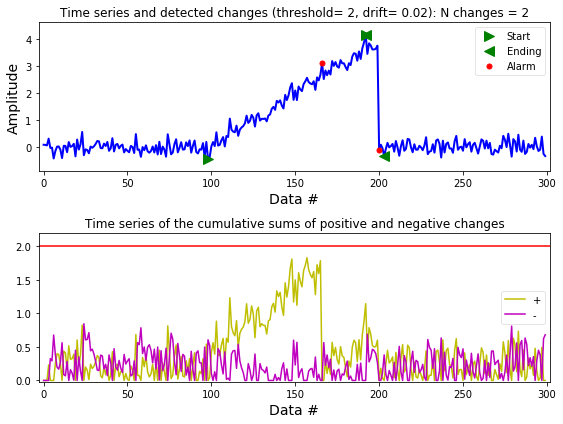

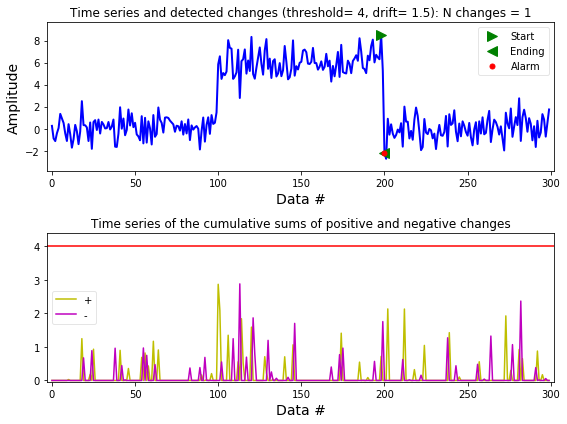

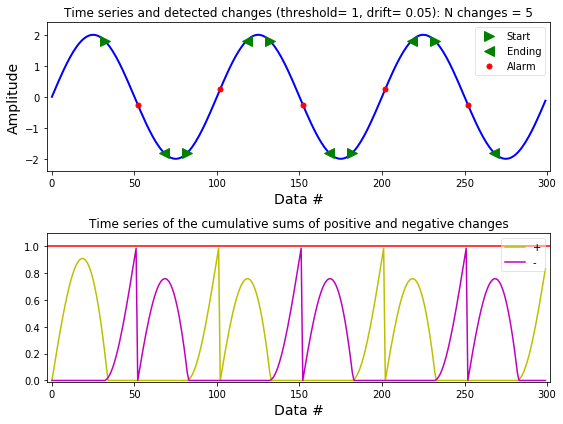

In [28]:
x = np.random.randn(300)/5
x[100:200] += np.arange(0, 4, 4/100)
ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

x = np.random.randn(300)
x[100:200] += 6
detect_cusum(x, 4, 1.5, True, True)
    
x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)

## Практика; Примените детектор к sig1 и sig2

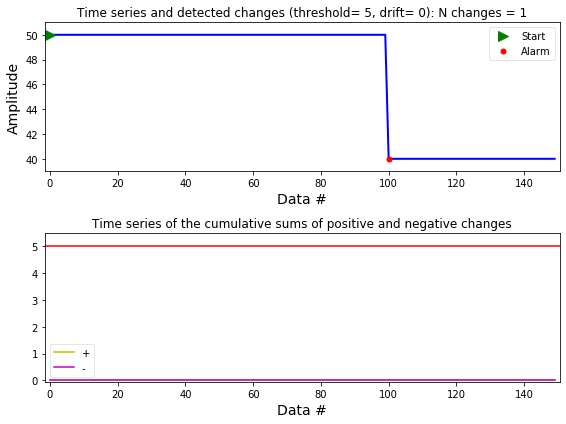

(array([100]), array([0]), array([], dtype=int64), array([], dtype=float64))

In [29]:
detect_cusum(sig1, threshold=5)

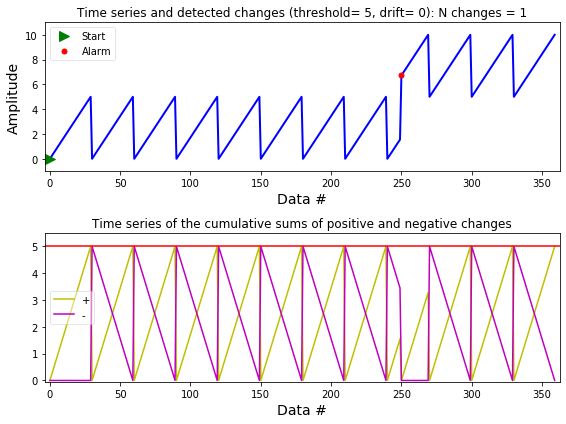

(array([250]), array([0]), array([], dtype=int64), array([], dtype=float64))

In [30]:
detect_cusum(sig2, threshold=5)

## 4. OneClass SVM

На пальцах - пытаемся отделить гипер-плоскостью пространство известных измерений от всего остального

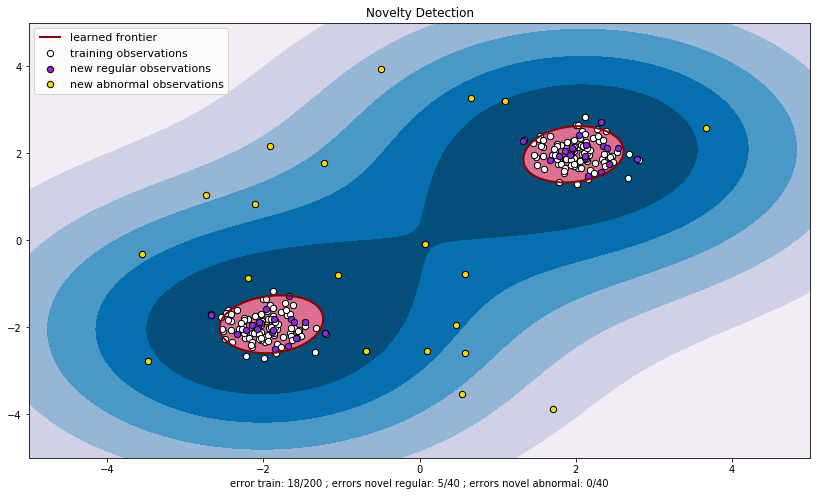

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14,8))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

### Sig 1

In [45]:
jump_size = sig1[0] - sig1[-1]

noise = np.random.normal(
    size=sig1.shape,
    scale=jump_size * 0.10)

sig1_noise = np.array(sig1 + noise).reshape(-1, 1)

In [46]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(sig1_noise[:80])

y_pred_train = clf.predict(sig1_noise[:80])
y_pred_test = clf.predict(sig1_noise[80:])

In [47]:
y = np.linspace(30, 70, 500).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(500)

In [48]:
sig1_noise.shape

(150, 1)

In [49]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, sig1_noise[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, sig1_noise[idx]))

In [50]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

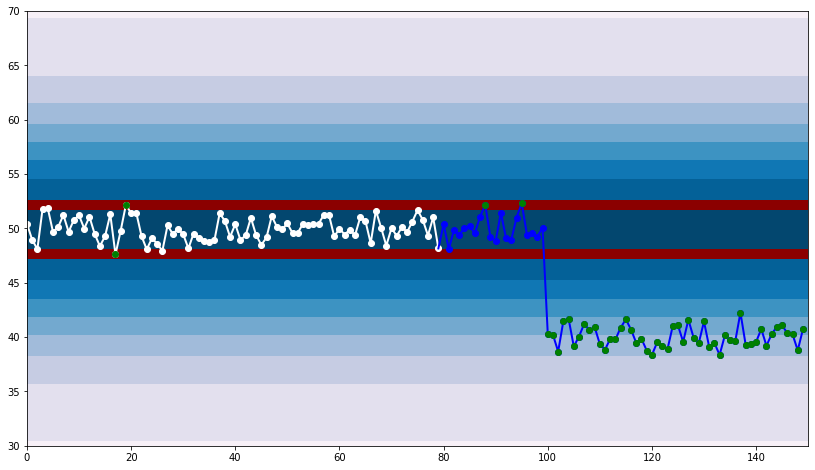

In [51]:
plt.figure(figsize=(14,8))
plt.contourf([0, 150], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 150], y, Z, levels=[0], linewidths=10, colors='darkred')
plt.plot(range(80), sig1_noise[:80], 'wo', linewidth=10)
plt.plot(range(80), sig1_noise[:80], 'w-', linewidth=2)
plt.plot(range(80,150), sig1_noise[80:], 'bo', linewidth=10)
plt.plot(range(79,150), sig1_noise[79:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

## Практика; Примените детектор к sig2

In [52]:
sig2 = sig2.reshape(-1, 1)

In [55]:
sig2.shape

(360, 1)

/Users/aleksandr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


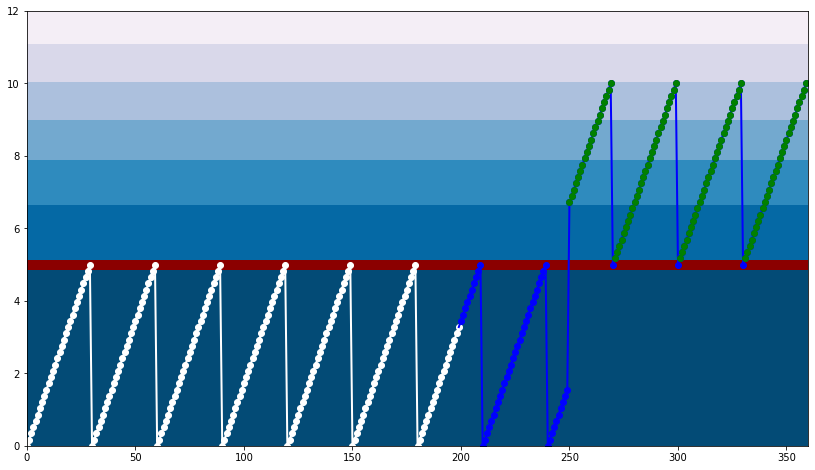

In [53]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.009)
clf.fit(sig2[:200])

y_pred_train = clf.predict(sig2[:200])
y_pred_test = clf.predict(sig2[200:])
y = np.linspace(0, 12, 500).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(500)

false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, sig2[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, sig2[idx]))

false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

plt.figure(figsize=(14,8))
plt.contourf([0, 360], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 360], y, Z, levels=[0], linewidths=10, colors='darkred')
plt.plot(range(200), sig2[:200], 'wo', linewidth=10)
plt.plot(range(200), sig2[:200], 'w-', linewidth=2)
plt.plot(range(200,360), sig2[200:360], 'bo', linewidth=10)
plt.plot(range(199,360), sig2[199:360], 'b-', linewidth=2)
if false_positive_train:
    plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')

plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

## Доп материалы
- https://github.com/amanahuja/change-detection-tutorial
- https://thisdata.com/blog/unsupervised-machine-learning-with-one-class-support-vector-machines/
- https://www.youtube.com/watch?v=srD9HoYUpVk&list=PLmWgutC0-hvVGRF6FyfB3mRcT_BLc9B0R

In [ ]:
pass

Выберите ряд, на котором происходит аномалия. Примените к нему все 4 способа поиска анамолий.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

from collections import deque, defaultdict
from sklearn import svm

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('./numbers-on-unemployment-benefits1.csv')
data.head()

,Month,Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992
0,1956-01,4742.0
1,1956-02,6128.0
2,1956-03,6494.0
3,1956-04,5379.0
4,1956-05,6011.0


In [5]:
series = data['Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992'].dropna()
series[:10]

0     4742.0
1     6128.0
2     6494.0
3     5379.0
4     6011.0
5     7003.0
6     9164.0
7    10333.0
8     9614.0
9     9545.0
Name: Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992, dtype: float64

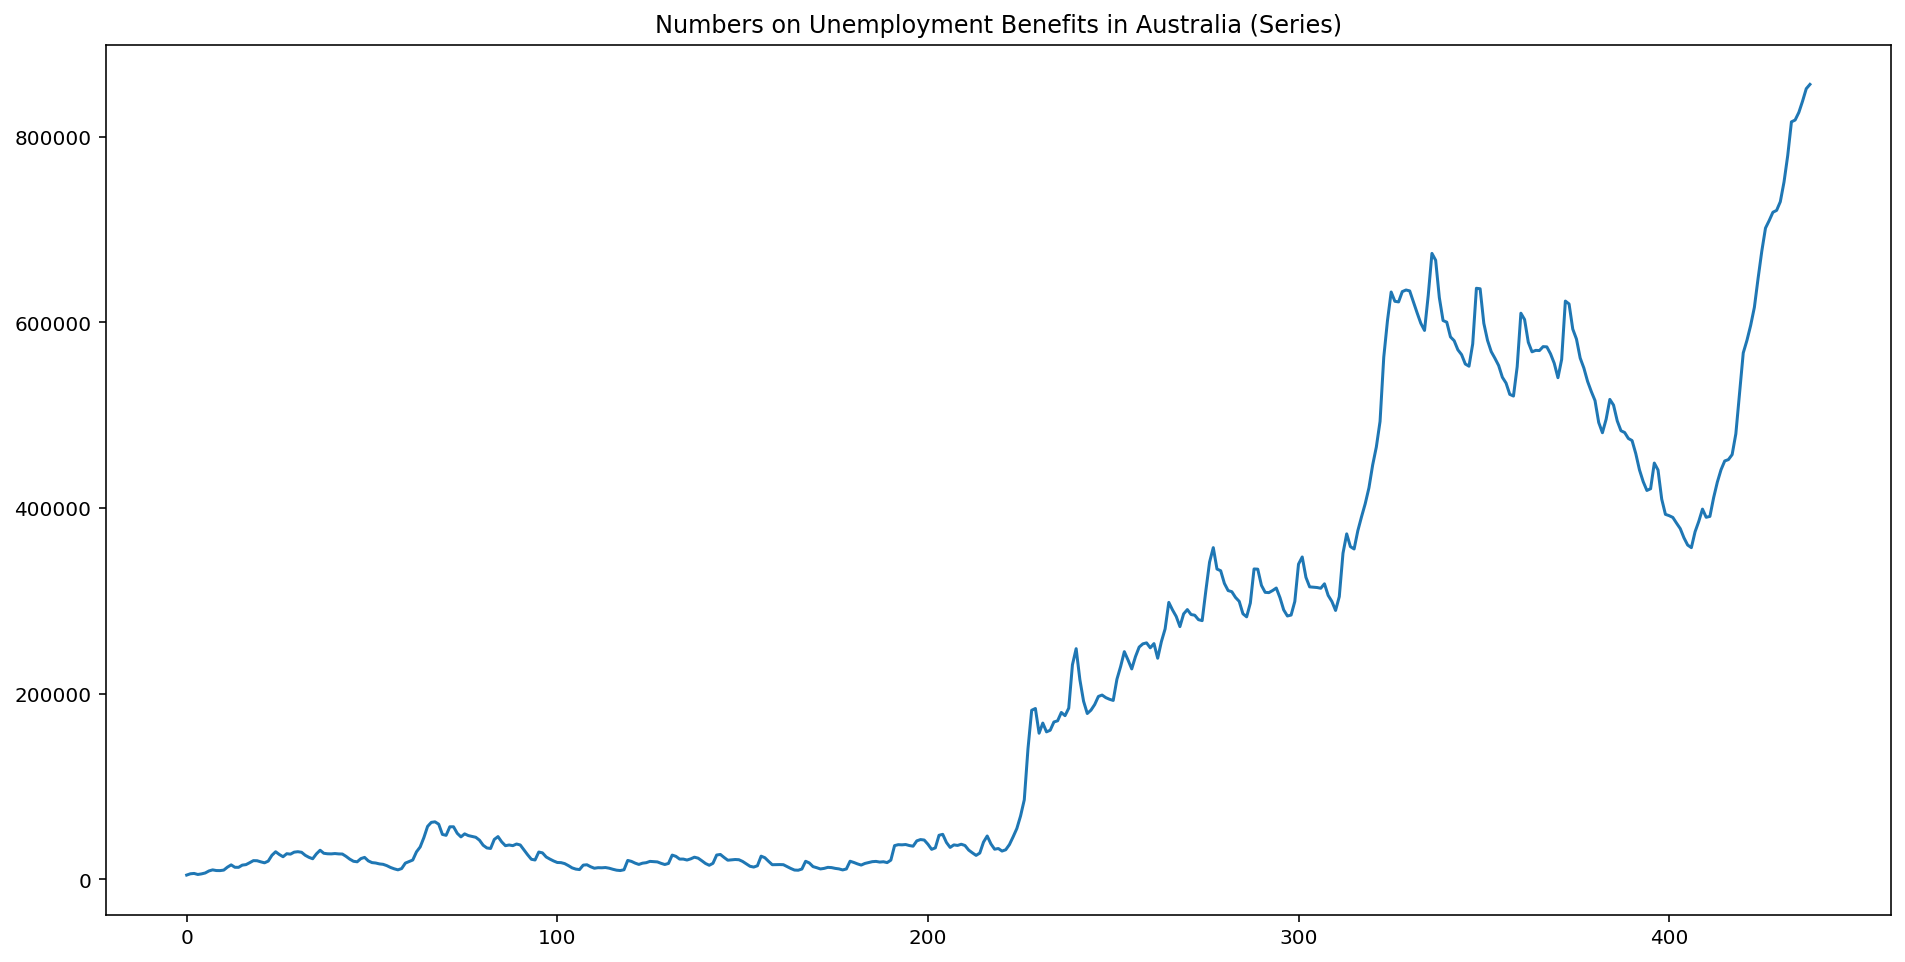

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Numbers on Unemployment Benefits in Australia (Series)')
plt.plot(series)
plt.show()

### 1. Простое мат ожидание

In [7]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

    
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,4))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

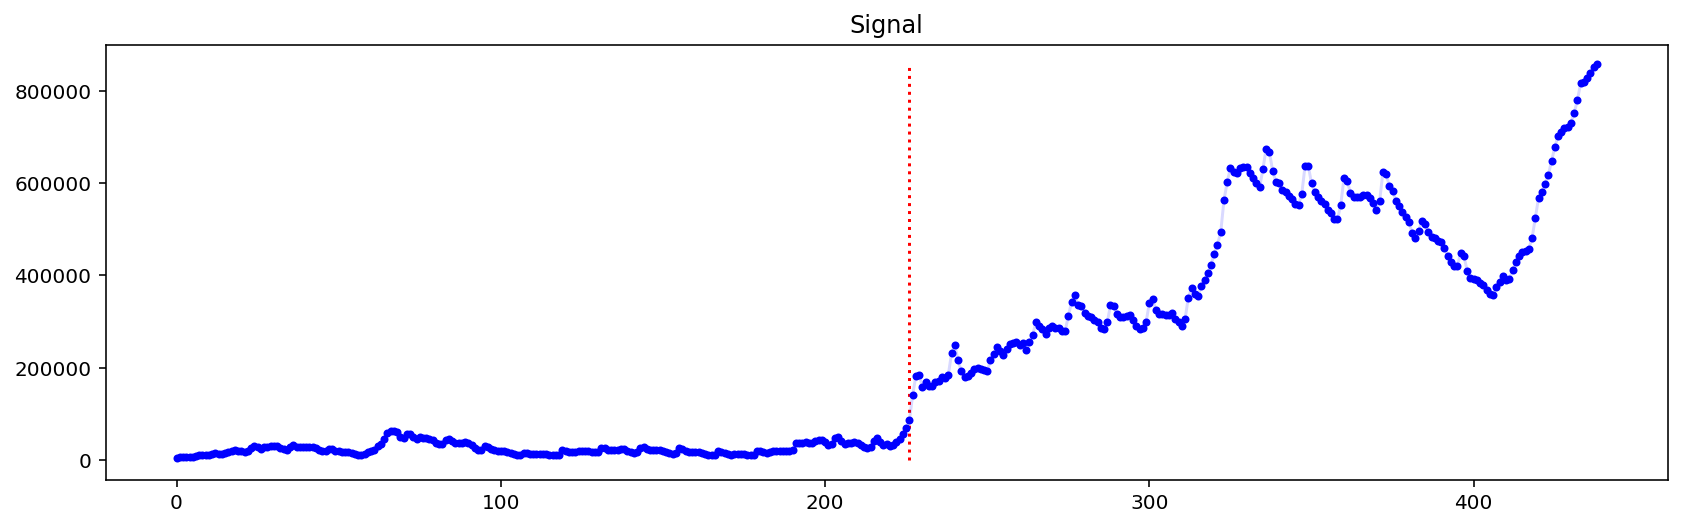

In [15]:
simulate(MeanDetector(2), series)

### 2. Потоковые окна

In [18]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

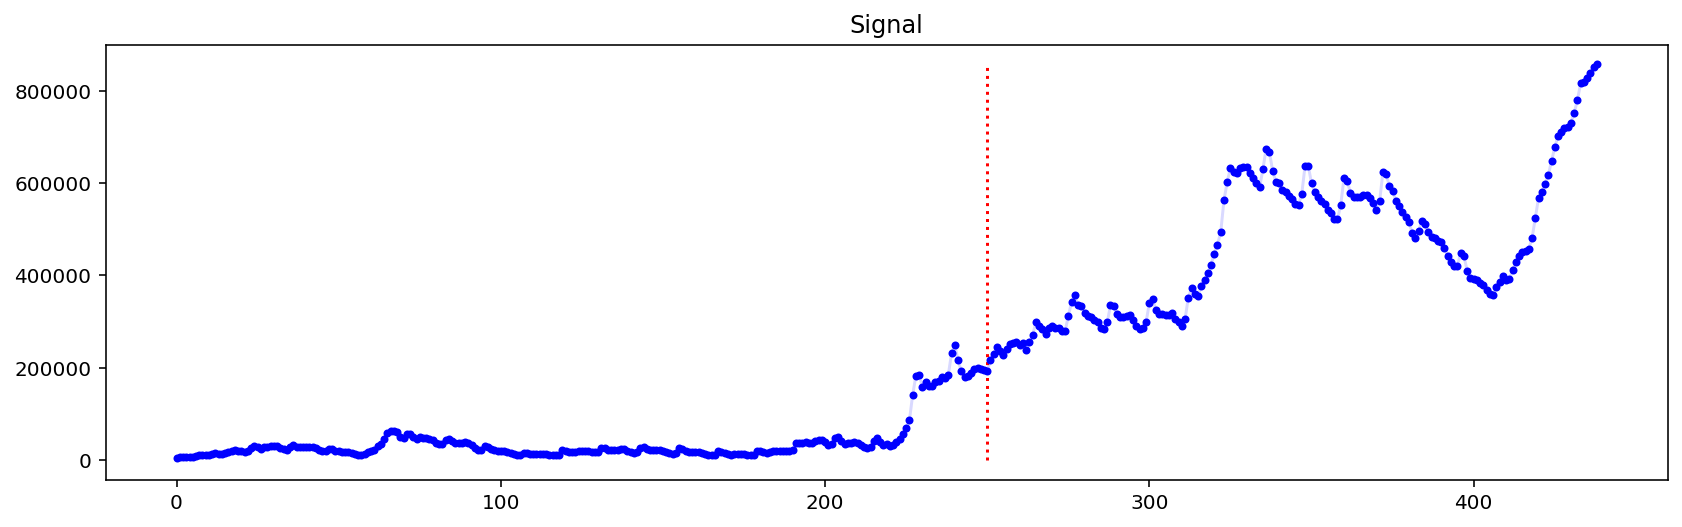

In [27]:
simulate(ZScoreDetector(window_size=100, threshold=5.0), series)

### 3. Кумулятивные суммы

In [28]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

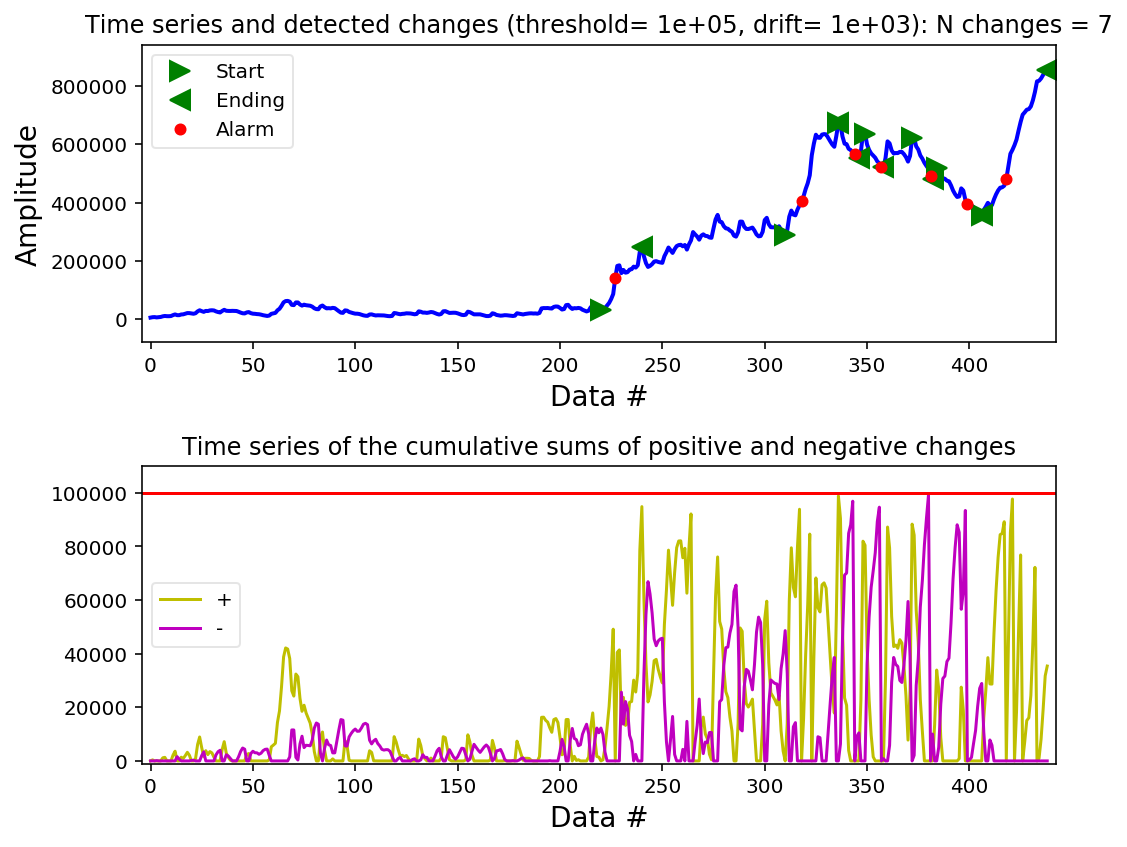

In [30]:
ta, tai, taf, amp = detect_cusum(series, 100000, 1000, True, True)

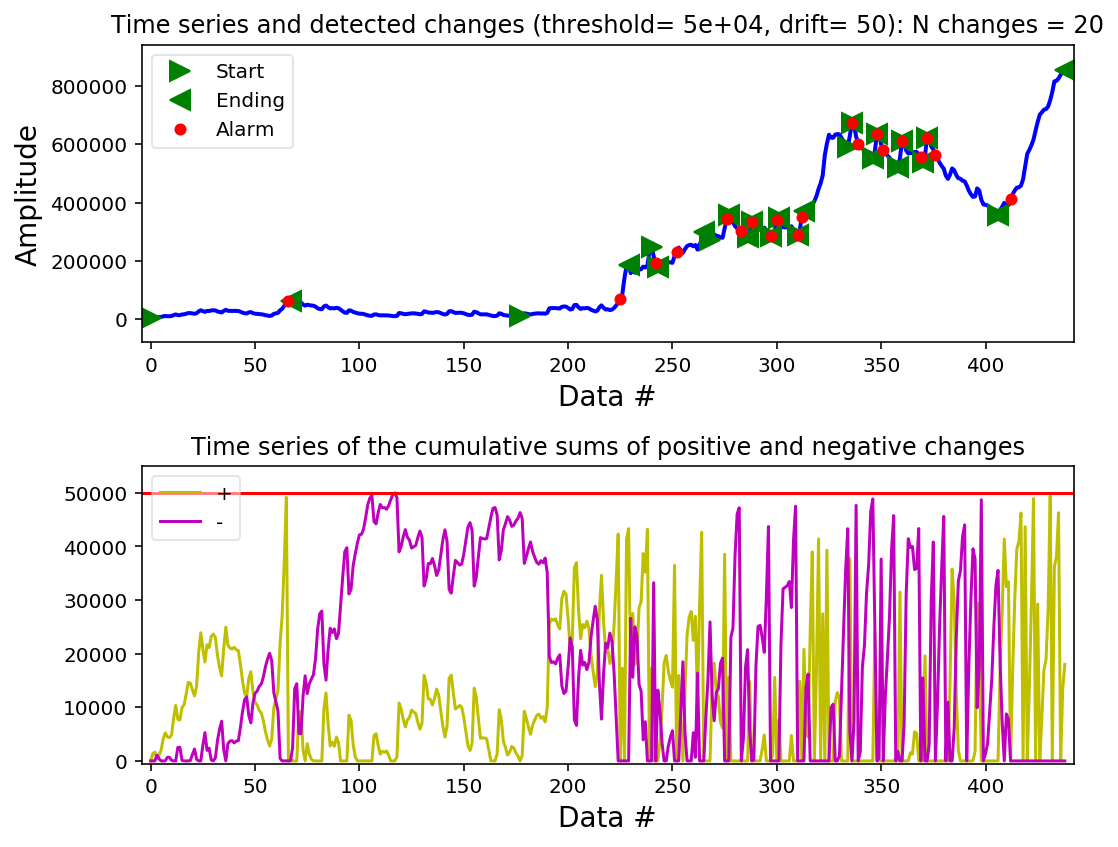

In [31]:
from ipywidgets import interact

@interact
def simulate_cumsum(threshold=(0, 100000, 1000), drift=(0, 100, 1)):
    detect_cusum(series, threshold, drift, True, True)

### 4. OneClass SVM

In [131]:
def OneClass_SVM(series=series, start=100, end=len(series), log=False, sqrt=False):
    
    OneClass = np.array(series).reshape(-1, 1)
    
    if log==True:
        OneClass = np.log(np.array(series).reshape(-1, 1))
    if sqrt==True:
        OneClass = np.sqrt(np.array(series).reshape(-1, 1))

    clf = svm.OneClassSVM(nu=0.01, kernel="rbf",degree=5 ,gamma=0.01)
    clf.fit(OneClass[:start])

    y_pred_train = clf.predict(OneClass[:start])
    y_pred_test = clf.predict(OneClass[start:end])

    y = np.linspace(0, np.amax(OneClass[:end]), end).reshape(-1, 1)
    Z = clf.decision_function(y).reshape(-1, 1)
    Z = np.hstack((Z, Z))
    y = y.reshape(end)

    false_positive_train = []
    false_positive_test = []

    for i, t in enumerate(y_pred_train):
        if t != 1:
            false_positive_train.append((i, OneClass[i]))

    for i, t in enumerate(y_pred_test):
        if t != 1:
            idx = len(y_pred_train) + i
            false_positive_test.append((idx, OneClass[idx]))

    false_positive_train = np.array(false_positive_train)
    false_positive_test = np.array(false_positive_test)

    plt.figure(figsize=(16,8))
    plt.contourf([0, end], y, Z, cmap=plt.cm.PuBu)
    plt.contour([0, end], y, Z, levels=[0], linewidths=10, colors='darkred', alpha=0.3)
    plt.plot(range(start), OneClass[:start], 'ro', linewidth=10)
    plt.plot(range(start), OneClass[:start], 'r-', linewidth=2)
    plt.plot(range(start,end), OneClass[start:], 'bo', linewidth=1)
    plt.plot(range(start+99,end), OneClass[start+99:], 'b-', linewidth=1)

    if len(false_positive_train)>0:
        plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go', alpha=0.5)

    if len(false_positive_test)>0:
        plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go', alpha=0.5)

    plt.show()

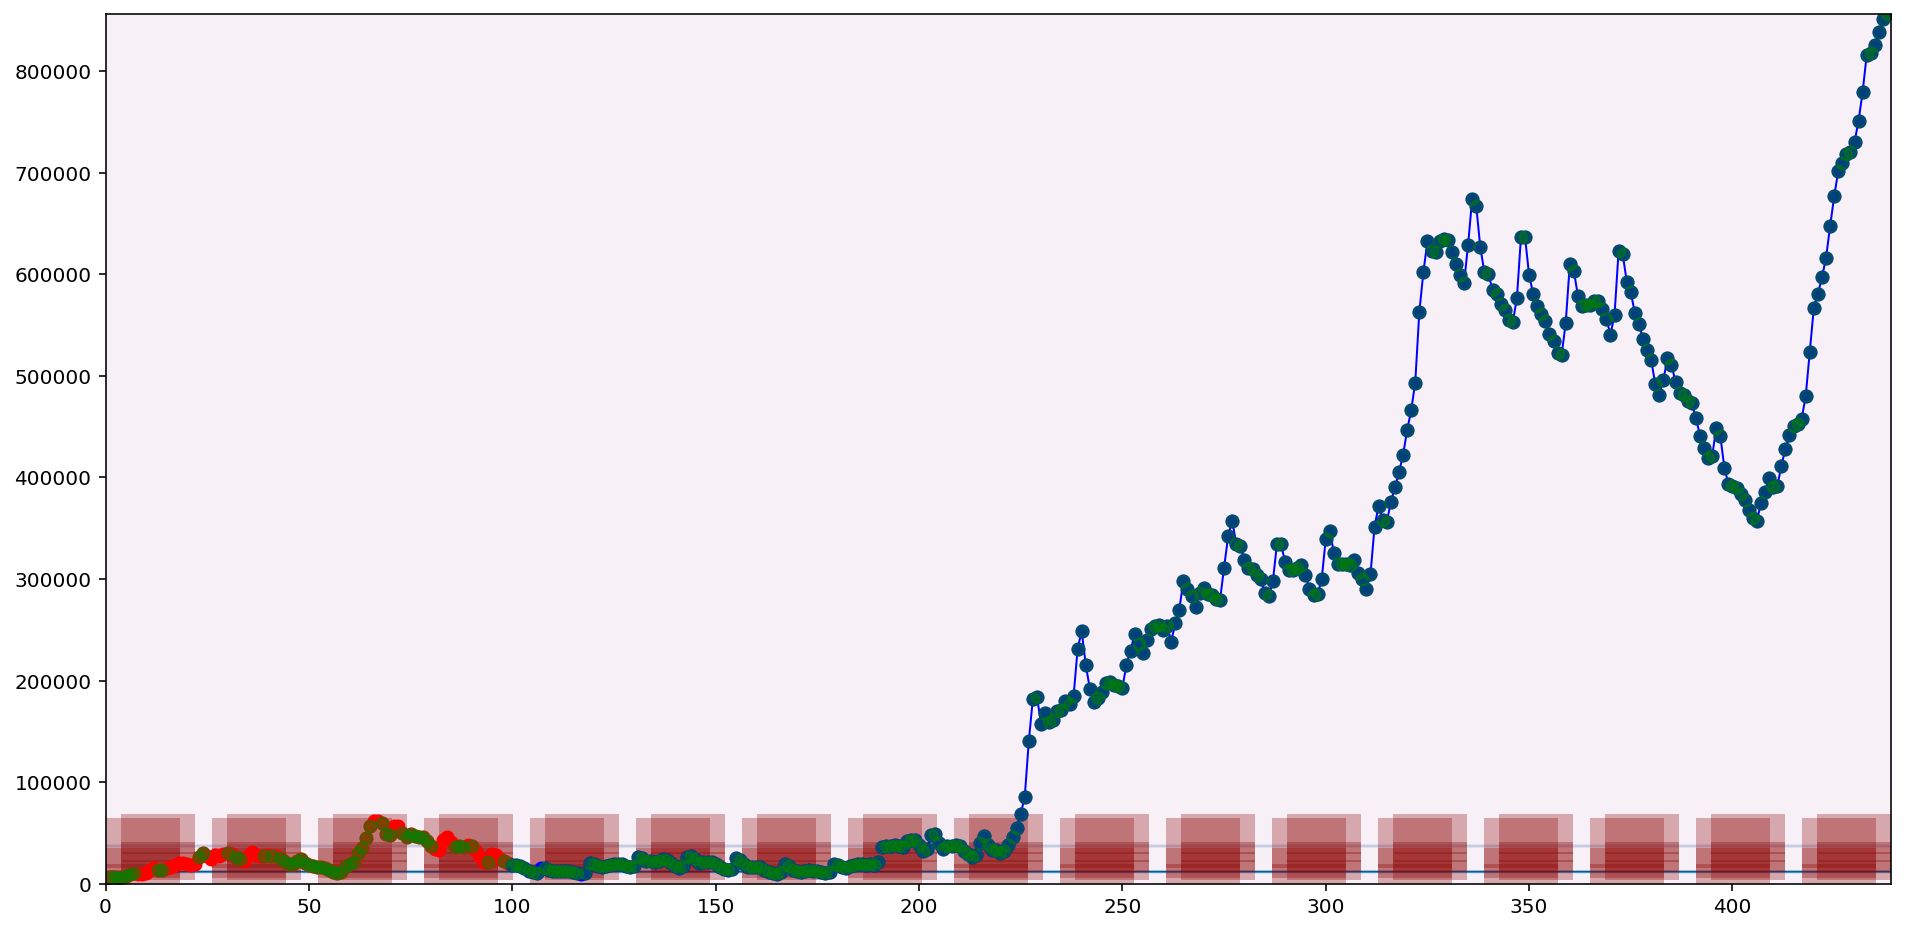

In [134]:
OneClass_SVM(series=series, start=100, end=len(series), log=False, sqrt=False)

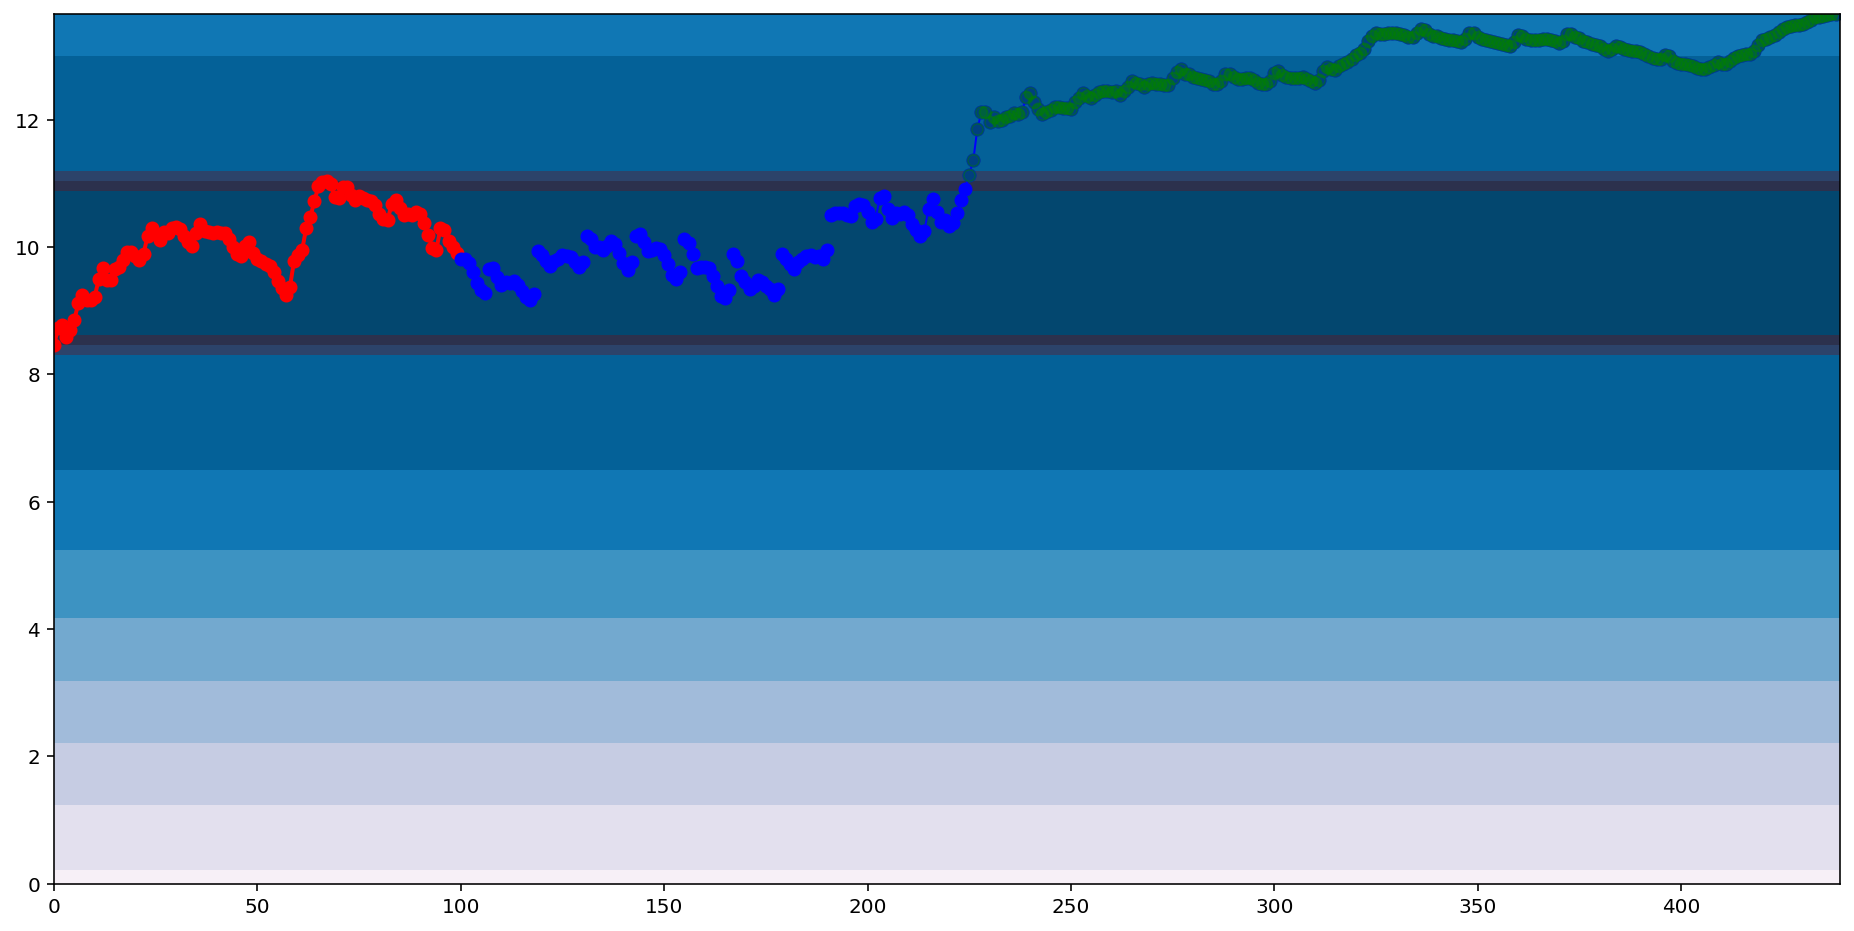

In [132]:
# Можно попробывать Логарифмировать
OneClass_SVM(series=series, start=100, end=len(series), log=True, sqrt=False)

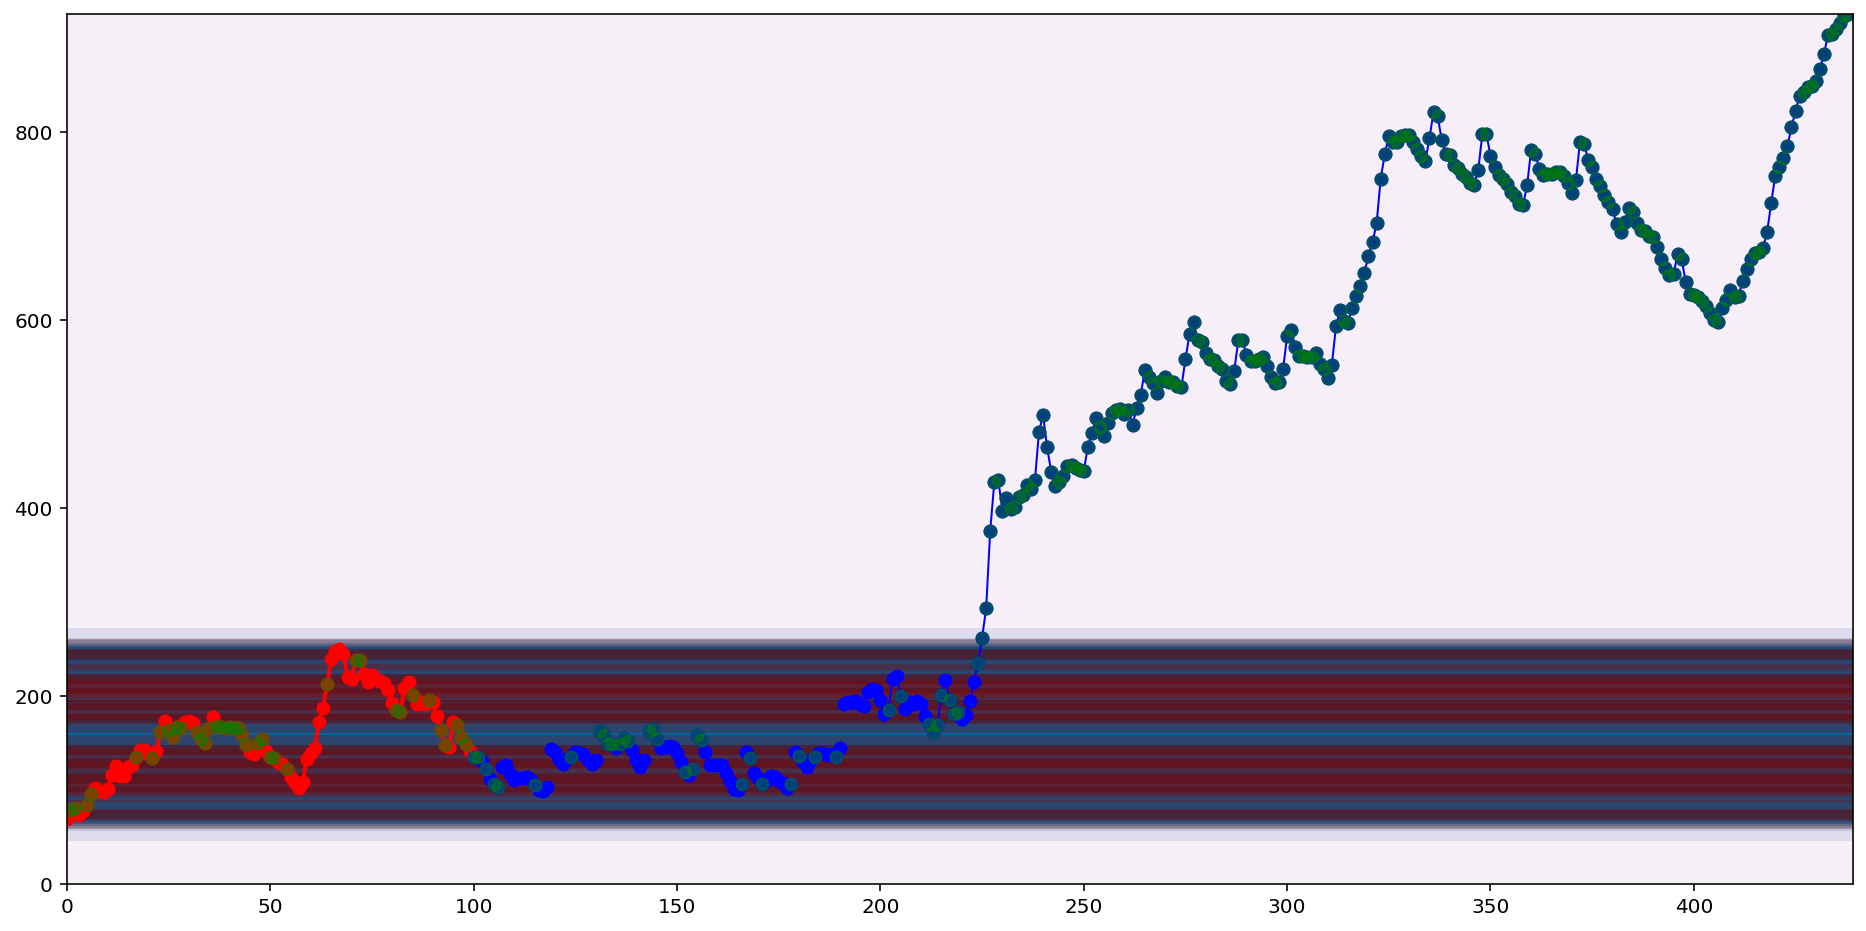

In [133]:
# Можно попробывать взять Квадратный корень
OneClass_SVM(series=series, start=100, end=len(series), log=False, sqrt=True)

In [ ]:
pass